# <center> <img src="figs/LogoUFSCar.jpg" alt="Logo UFScar" width="110" align="left"/>  <br/> <center>Universidade Federal de São Carlos (UFSCar)<br/><font size="4"> Departamento de Computação, campus Sorocaba</center></font>
</p>

<font size="4"><center><b>Disciplina: Aprendizado de Máquina</b></center></font>
  
<font size="3"><center>Prof. Dr. Tiago A. Almeida</center></font>

## <center>Projeto Final</center>

**Nome**: Anderson Cristiano Sassaki Gonçalves e Lorenzo Grippo Chiachio

**RA**: 821675 e 823917


---
### Análise exploratória

Nesta seção, deve ser feita a leitura da base de dados e todas as análises necessárias para interpretar e analisar os dados, tais como:
* Significado de cada atributo
* Medidas descritivas
* Gráficos

#### Análise inicial dos dados

Utilizaremos a biblioteca pandas para ler o arquivo train.csv e carregá-lo em uma estrutura de dados DataFrame. Após o carregamento, uma inspeção inicial será realizada exibindo as cinco primeiras entradas para verificar os dados e entender a sua estrutura, incluindo os nomes das colunas e o formato dos valores.

In [ ]:
import pandas as pd
TRAIN_CSV_PATH = 'dataset/train.csv'

try:
    df_train = pd.read_csv(TRAIN_CSV_PATH)
    print("Arquivo train.csv carregado com sucesso!")

    print("Primeiras amostras do conjunto de treino:")
    display(df_train.head(n=5))

except FileNotFoundError:
    print(f"Erro: Arquivo {TRAIN_CSV_PATH} não encontrado.")

Depois de carregar os dados, o próximo passo é checar como as nossas três classes (`STRESS`, `AEROBIC`, `ANAEROBIC`) estão distribuídas no conjunto de treino. É importante fazer isso para ver se o dataset é balanceado. Se tivéssemos, por exemplo, muito mais amostras de `STRESS` do que das outras, o nosso modelo poderia ficar "viciado" em prever `STRESS` e não aprenderia a reconhecer bem as outras classes.

In [ ]:
import matplotlib.pyplot as plt

label_counts = df_train['Label'].value_counts()

plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar', color=['skyblue', 'salmon', 'lightgreen'])

# Título e rótulos
plt.title('Distribuição das Classes')
plt.xlabel('Classe')
plt.ylabel('Frequência')
plt.xticks(rotation=0) # Mantém os nomes das labels na horizontal

# Adiciona o valor exato no topo de cada barra
for index, value in enumerate(label_counts):
    plt.text(index, value + 0.5, str(value), ha='center', va='bottom')

plt.grid(axis='y', linestyle='--', alpha=1)
plt.tight_layout()
plt.show()

A inspeção do histograma de frequências revela uma distribuição de classes equilibrada. Com 28 instâncias para a classe ANAEROBIC, 25 para STRESS e 22 para AEROBIC, a contagem de amostras por categoria aproxima-se de uma distribuição uniforme. Essa homogeneidade no conjunto de treinamento é uma característica desejável. Baseado nisso, consideramos que a aplicação de técnicas de reamostragem para correção de desbalanceamento é desnecessária nesta fase do projeto.

Seguindo com os testes, verificamos que todos as amostras do conjunto de treinamento tenham um rótulo de classe (Label) válido, uma vez que amostras sem rótulos seriam inutilizáveis para o treinamento supervisionado. Além disso, realizamos uma varredura nos arquivos de sinais brutos associados a cada amostra de treino.

O objetivo é verificar três problemas potenciais:
- Arquivos ausentes: o arquivo de um sensor para uma determinada amostra não existe.
- Arquivos vazios: o arquivo existe, mas não contém nenhum dado.
- Valores nulos (NaN): o arquivo contém dados, mas com buracos ou leituras inválidas.


In [ ]:
import sys
sys.path.append('scripts')

from analise_exploratoria import check_data_integrity

missing_labels = df_train.isnull().sum()
if missing_labels.sum() == 0:
    print("Não há valores ausentes no arquivo de rótulos (train.csv).")
else:
    print("Foram encontrados os seguintes valores ausentes nos rótulos:")
    print(missing_labels[missing_labels > 0])

integrity_report = check_data_integrity(df_train, base_dir='dataset/wearables/', verbose=True)

if not integrity_report:
    print("Nenhuma amostra de treino possui arquivos de sensores ausentes, vazios ou com valores NaN internos.")
else:
    num_problematic_samples = len(integrity_report)
    print(f"{num_problematic_samples} amostra(s) apresentaram problemas de integridade.")

O arquivo de rótulos está correto, com todos os rótulos presentes para cada amostra. Porém, a análise de integridade dos arquivos de sensores revelou uma anomalia: a amostra U_89740 possui um arquivo IBI.csv vazio. Para evitar o descarte completo da amostra, a etapa de pré-processamento irá lidar com essa exceção.

Durante a extração de características, se um arquivo de sensor for encontrado vazio, as features correspondentes (ex: IBI_mean, IBI_std) serão imputadas com um valor neutro (como a média da coluna calculada a partir das outras amostras). Isso permite que a amostra U_89740 continue a ser utilizada no treinamento, aproveitando a informação dos seus 5 sensores restantes.

#### Análise dos sensores

Para compreender os dados que alimentarão nossos modelos, é fundamental entender o significado de cada sinal fisiológico coletado pelos sensores vestíveis. Cada sensor captura uma dimensão diferente da resposta do corpo ao estresse e ao exercício. A figura produzida pela célula abaixo apresenta uma visualização dos seis sinais brutos para uma única amostra selecionada aleatoriamente.

In [ ]:
import sys
sys.path.append('scripts')

from analise_exploratoria import plot_all_sensors_for_random_sample

plot_all_sensors_for_random_sample(
    dataset=df_train,
    base_dir='dataset/wearables'
)

**1. HR (Heart Rate - Frequência Cardíaca)**
*   Medido em batimentos por minuto (BPM), representa a frequência dos batimentos cardíacos. É um dos indicadores mais diretos de esforço físico e estresse.
*   O gráfico de `HR` mostra a tendência da frequência cardíaca ao longo da atividade. Em atividades de exercício (`AEROBIC`, `ANAEROBIC`), esperamos observar valores médios mais altos e uma subida no início. Em `STRESS`, os valores podem ser elevados, mas geralmente inferiores aos de um exercício intenso.

**2. EDA (Electrodermal Activity - Atividade Eletrodérmica)**
*   Mede a condutividade elétrica da pele em microsiemens (μS), que está diretamente ligada à atividade das glândulas sudoríparas. É um forte indicador da resposta do sistema nervoso simpático, associado à excitação emocional e ao estresse.
*   O sinal `EDA` é composto por um nível de base (tônico) e picos rápidos (fásicos). Um grande número de picos ou uma tendência de subida no nível de base, como visto no gráfico, sugere um estado de alta excitação, tornando este sensor crucial para a detecção de `STRESS`.

**3. TEMP (Skin Temperature - Temperatura da Pele)**
*   Mede a temperatura da superfície da pele em graus Celsius (°C). É influenciada pelo fluxo sanguíneo periférico, que pode diminuir sob estresse (vasoconstrição) ou aumentar durante o exercício para dissipar calor.
*   O gráfico de `TEMP` tende a apresentar variações mais lentas em comparação com outros sensores. É útil para observar tendências de longo prazo de aquecimento ou resfriamento durante a sessão.

**4. BVP (Blood Volume Pulse - Pulso de Volume Sanguíneo)**
*   Sinal bruto do sensor de fotopletismografia (PPG) que mede a variação do volume de sangue nos tecidos. Cada pico na onda corresponde a um batimento cardíaco.
*   O gráfico de `BVP` é uma onda de alta frequência e densa. Embora sua interpretação direta seja complexa, ele é a fonte primária a partir da qual os sinais mais informativos de **HR** e **IBI** são extraídos por algoritmos de detecção de picos.

**5. ACC (3-axis Accelerometer - Acelerômetro de 3 Eixos)**
*   Mede a aceleração do movimento em três eixos espaciais (X, Y, Z). É o indicador mais direto de atividade física.
*   As três linhas no gráfico `ACC` representam o movimento em cada direção. Sinais com baixa amplitude e variação indicam inatividade (típico de `STRESS`). Sinais com alta amplitude e variação, indicam movimento intenso e contínuo, característico de `AEROBIC` ou `ANAEROBIC`. A magnitude combinada dos três eixos é uma característica que pode ser utilizada para quantificar a intensidade do movimento.

**6. IBI (Inter-Beat Interval - Intervalo Inter-Batimento)**
*   Representa o tempo, em segundos, entre batimentos cardíacos consecutivos.
*   O gráfico de `IBI` é uma série de pontos, não uma linha contínua. A variabilidade na altura desses pontos é conhecida como Variabilidade da Frequência Cardíaca (HRV). Uma baixa variabilidade (pontos muito alinhados horizontalmente) é um forte indicador de estresse físico ou mental, enquanto uma alta variabilidade (pontos mais "espalhados" verticalmente) está associada a um estado de relaxamento.

A próxima etapa da análise exploratória consiste em uma inspeção visual sistemática das séries temporais brutas. O objetivo é visualizar o sinal de cada um dos 6 sensores para todas as amostras do conjunto de treino, agrupadas por sua respectiva classe (`STRESS`, `AEROBIC`, `ANAEROBIC`).

Essa abordagem visa alcançar os seguintes diagnósticos:
1.  **Identificar Padrões de Comportamento:** Observar a estrutura típica do sinal para cada estado fisiológico.
2.  **Avaliar a Variabilidade Intra-classe:** Entender o quão similares ou diferentes são as medições entre participantes da mesma classe.
3.  **Detectar Anomalias Grosseiras:** Identificar visualmente outliers, erros de sensor ou arquivos corrompidos que exigirão tratamento na fase de pré-processamento.

Os gráficos resultantes serão salvos na pasta `figs/analise_atributos` para documentação e referência futura.

In [ ]:
import pandas as pd
import sys
sys.path.append('scripts')

from analise_exploratoria import plot_signal_distribution_for_class

try:
    csv_path = 'dataset/train.csv'
    df_train = pd.read_csv(csv_path)
    print("Dataset de treino carregado com sucesso.")
except FileNotFoundError:
    print(f"Erro: Arquivo não encontrado em '{csv_path}'.")
    df_train = None


if df_train is not None:
    sensors_to_plot = ['TEMP.csv', 'HR.csv', 'EDA.csv', 'BVP.csv', 'ACC.csv', 'IBI.csv']
    classes_to_plot = ['STRESS', 'AEROBIC', 'ANAEROBIC']

    base_dir_path = 'dataset/wearables'
    output_dir_path = 'figs/analise_atributos'

    for sensor in sensors_to_plot:
        for target_class in classes_to_plot:
            print(f"Plotando para a classe: {target_class}...")

            plot_signal_distribution_for_class(
                dataset=df_train,
                target_class=target_class,
                sensor_name=sensor,
                base_dir=base_dir_path,
                output_dir=output_dir_path,
                cols=5,
                save_fig=True,
                show_fig=False,
                verbose=False,
            )
    print("\nTodos os gráficos foram gerados e salvos com sucesso!")

A inspeção dos gráficos gerados confirmou a presença de anomalias nos dados brutos. Foram identificados valores fisiologicamente inconcebíveis em múltiplas amostras, notadamente leituras de frequência cardíaca (`HR`) que excedem 1000 BPM e de temperatura (`TEMP`) que atingem 200°C. Esses valores são evidentes erros de medição que se não tratados podem comprometer o desempenho do modelo.

Selecionamos três exemplos representativos dessas anomalias (apresentados abaixo). Posteriormente, na seção de pré-processamento, esperamos realizar a correção desses valores.

<p align="center" style="display:flex; justify-content:center;">
  <img src="figs/selected_images/hr_sensor.png" style="width:300px; height:250px; object-fit:contain;">
  <img src="figs/selected_images/temp1_sensor.png" style="width:300px; height:250px; object-fit:contain;">
  <img src="figs/selected_images/temp2_sensor.png" style="width:300px; height:250px; object-fit:contain;">
</p>



Para aprofundar a detecção de outliers, complementamos a inspeção visual com uma análise estatística por meio de box plots. Nesta etapa, geramos um gráfico de box plot para cada amostra individual, agrupando-os por classe e por tipo de sensor. Essa abordagem nos permite diagnosticar duas formas de anomalias:
1.  Outliers Intra-Amostra: Pontos de dados que se desviam significativamente da distribuição principal dentro de uma única gravação (representados como pontos fora dos "bigodes" do box plot).
2.  Amostras Anômalas: Casos em que a distribuição inteira de uma amostra (a "caixa") difere drasticamente das outras amostras da mesma classe.

Os gráficos resultantes serão salvos na pasta `figs/boxplots` e servirão como uma ferramenta quantitativa para guiar e validar a nossa etapa de limpeza de dados.

In [ ]:
import pandas as pd
import sys
sys.path.append('scripts')

from analise_exploratoria import plot_boxplot_comparison_for_class

try:
    csv_path = 'dataset/train.csv'
    df_train = pd.read_csv(csv_path)
    print("Dataset de treino carregado com sucesso.")
except FileNotFoundError:
    print(f"Erro: Arquivo não encontrado em '{csv_path}'.")
    df_train = None


if df_train is not None:
    sensors_to_plot = ['TEMP.csv', 'HR.csv', 'EDA.csv', 'BVP.csv', 'ACC.csv', 'IBI.csv']
    classes_to_plot = ['STRESS', 'AEROBIC', 'ANAEROBIC']

    base_dir_path = 'dataset/wearables'
    output_dir_path = 'figs/boxplots'

    for sensor in sensors_to_plot:
        for target_class in classes_to_plot:
            print(f"Plotando para a classe: {target_class}...")

            plot_boxplot_comparison_for_class(
                dataset=df_train,
                target_class=target_class,
                sensor_name=sensor,
                base_dir=base_dir_path,
                output_dir=output_dir_path,
                save_fig=True,
                show_fig=False,
                verbose=False,
            )
    print("\nTodos os gráficos foram gerados e salvos com sucesso!")

A análise dos box plots confirma e quantifica as observações da inspeção visual anterior: a presença de diversos outliers nos dados brutos. Os gráficos (exemplificados abaixo) revelam pontos de dados que extrapolam significativamente os limites do intervalo interquartil, o que reforça a necessidade de um tratamento robusto de outliers na fase de pré-processamento.

Para validar a eficácia do nosso pipeline de limpeza, selecionamos três exemplos representativos que servirão como referência de comparação "antes" e "depois".

<div style="text-align:center;">
  <img src="figs/selected_images/HR_STRESS.png" width="450">
  <img src="figs/selected_images/TEMP_AEROBIC.png" width="450">
  <img src="figs/selected_images/EDA_AEROBIC.png" width="450">
</div>

#### Nota sobre o Acelerômetro (ACC)

É importante notar que, para o sensor de acelerômetro, a análise não foi realizada nos três eixos (X, Y, Z) separadamente. Em vez disso, optou-se por calcular a Magnitude do Vetor de Sinal (`√(X² + Y² + Z²)`). Essa abordagem transforma os três sinais direcionais em uma única métrica que representa a intensidade total do movimento, independentemente da orientação do sensor. Isso não apenas simplifica a visualização, mas também cria uma característica mais robusta e intuitiva.

#### Análise dos dados demográficos

Iniciamos agora a análise dos dados demográficos, contidos no arquivo `users_info.txt`. Estes dados são importantes para caracterizar o perfil dos participantes do estudo e, posteriormente, investigar se fatores como idade, gênero ou nível de atividade física influenciam as respostas fisiológicas.

O processo de carregamento destes dados requer uma atenção especial, pois o arquivo de origem (`.txt`) contém linhas de rodapé com referências que não são parte dos dados. Além disso, valores ausentes são representados pelo caractere `-`. Após o carregamento, realizamos uma inspeção inicial com os métodos `.info()` e `.isnull().sum()` para verificar a estrutura do DataFrame, os tipos de dados inferidos e a quantidade de valores ausentes em cada coluna.

In [ ]:
import pandas as pd

USERS_INFO_PATH = 'dataset/users_info.txt'

try:
    df_users = pd.read_csv(
        USERS_INFO_PATH,
        na_values='-',
        skipfooter=10,               # Ignora as últimas 10 linhas do arquivo
        engine='python'
    )

    print("Arquivo users_info.txt carregado.")

    print("\nContagem de valores ausentes por coluna:")
    print(df_users.isnull().sum())

    print("\nPrimeiras 5 linhas do DataFrame carregado:")
    display(df_users.head(n=5))

except FileNotFoundError:
    print(f"Erro: {USERS_INFO_PATH} não encontrado.")
except Exception as e:
    print(f"Ocorreu um erro: {e}")

Após o carregamento e a limpeza inicial, realizamos agora uma análise visual dos dados demográficos. Para garantir que nossa análise reflita apenas os dados que serão utilizados no treinamento, filtramos as informações para incluir apenas os participantes presentes no conjunto de treino (`train.csv`).

A célula a seguir gera uma grade de gráficos com diferentes objetivos:
1.  Análise Univariada: Visualizar a distribuição de cada característica demográfica individualmente (Gênero, Idade, Altura, Peso, etc.).
2.  Análise de Relações: Investigar a correlação entre pares de variáveis numéricas (ex: Altura vs. Peso).
3.  Análise Cruzada: Cruzar as características demográficas com os rótulos de classe (`Label`) para verificar se há algum viés na distribuição das atividades entre os diferentes perfis de participantes.

In [ ]:
import sys
sys.path.append('scripts')

from analise_exploratoria import plot_demographic_analysis

if 'df_users' in locals() and 'df_train' in locals():
    plot_demographic_analysis(df_train=df_train, df_users=df_users)
else:
    print("Os DataFrames 'df_users' e/ou 'df_train' não foram encontrados.")

Os gráficos acima confirmam a integridade dos dados demográficos. Observamos uma população majoritariamente jovem e fisicamente ativa, com uma predominância do gênero masculino. As variáveis biométricas (peso e altura) apresentam consistência estatística. A distribuição das classes alvo (Stress, Aerobic, Anaerobic) mantém-se coerente quando segmentada por gênero e hábitos de atividade física, indicando que não há subgrupos demográficos críticos sem representatividade nas classes de treino. Podemos tentar utilizar os dados demográficos para treinar os modelos futuramente.

#### Medidas descritivas

Para obter um resumo quantitativo inicial dos dados brutos, calculamos um conjunto de medidas descritivas (média, desvio padrão, mediana, etc.) para cada sinal de cada amostra de treino. Em seguida, agregamos esses valores calculando a média dessas estatísticas por classe.

Esta abordagem nos permite uma primeira comparação numérica do comportamento dos sinais em cada estado fisiológico, mesmo antes da etapa de limpeza de outliers.

In [ ]:
import sys
sys.path.append('scripts')

from analise_exploratoria import analyze_raw_signal_stats

if 'df_train' in locals():
    analyze_raw_signal_stats(df_train=df_train, base_dir='dataset/wearables')
else:
    print("O DataFrame 'df_train' não foi encontrado. Execute a célula de carregamento primeiro.")

As tabelas acima reforçam as hipóteses da análise visual. Observa-se que a média da frequência cardíaca (`HR_mean`) e temperatura (`TEMP_mean`) são numericamente muito mais altas para as classes `AEROBIC` e `ANAEROBIC` em comparação com `STRESS`. Além disso, a média do desvio padrão do sinal EDA (`EDA_std`) é menor para a classe `STRESS`, indicando maior variabilidade.

É importante notar que estes valores foram calculados sobre os dados brutos e podem estar influenciados por dados ruidosos não tratados. No entanto, eles já fornecem evidência quantitativa da separabilidade das classes e fornecem uma base para a seleção de características que faremos na etapa de pré-processamento. Com uma noção dos dados que temos desenvolvidas, agora podemos passar para a próxima etapa.

---
### Pré-processamento

Nesta seção, as funções da etapa de pré-processamento dos dados devem ser implementadas e aplicadas (se necessário).

Conforme identificado na Análise Exploratória, o arquivo `users_info.txt` contém valores ausentes que precisam ser tratados antes que esses dados possam ser utilizados como possiveis características para o modelo. Além disso, as variáveis categóricas (como 'Gender' e 'Protocol') devem ser convertidas para um formato numérico que o modelo possa compreender.

A célula a seguir executa a função `preprocess_user_info`, que realiza um pipeline completo de limpeza e transformação nestes dados. O processo consiste nos seguintes passos:

1.  **Checagem de valores ausentes:**
    *   Para variáveis quantitativas (`Age`, `Height`, `Weight`), os valores nulos (`NaN`) são preenchidos com a média da respectiva coluna.
    *   Para variáveis qualitativas (`Does physical activity regularly?`), os nulos são preenchidos com a moda.

2.  **Codificação (Encoding) de Variáveis Categóricas:**
    *   A variável binária `Does physical activity regularly?` é mapeada para `1` (Yes) e `0` (No).
    *   As variáveis `Gender` e `Protocol` são transformadas usando a técnica de One-Hot Encoding.

3.  **Remoção de Colunas de Condição:** As colunas que descrevem a participação no experimento (`Stress Inducement`, etc.) são removidas.

Ao final, a função retorna um `DataFrame` (`df_users_processed`) com os dados demográficos limpos, imputados e codificados, pronto para ser integrado ao nosso conjunto de características.

In [1]:
import sys
sys.path.append('scripts')
from preprocessamento import preprocess_user_info

USERS_INFO_PATH = 'dataset/users_info.txt'
df_users_processed = preprocess_user_info(USERS_INFO_PATH)

if df_users_processed is not None:
    print("\n--- DataFrame Final Processado ---")
    display(df_users_processed.head())
    print("\nVerificação final de valores nulos:")
    print(df_users_processed.isnull().sum().sum())

Arquivo carregado. Dimensão inicial: (100, 10)
Limpeza de caracteres especiais (*) e espaços concluída.
Colunas estáticas removidas: ['Stress Inducement', 'Aerobic Exercise', 'Anaerobic Exercise']

--- Imputação ---
'Age': NaNs preenchidos com Média (22.3)
'Height (cm)': NaNs preenchidos com Média (171.7)
'Weight (kg)': NaNs preenchidos com Média (69.6)
'Does physical activity regularly?': NaNs preenchidos com Moda ('Yes')

--- Codificação ---
Pré-processamento demográfico concluído.

--- DataFrame Final Processado ---


,Id,Age,Height (cm),Weight (kg),activity_regularly,is_male,is_protocol_v2
0,U_21920,22.000000,173.000000,78.000000,1,1,0
1,U_27250,20.000000,185.000000,95.000000,0,1,0
2,U_82422,22.329787,171.712766,69.617021,1,0,1
3,U_35900,21.000000,175.000000,65.000000,1,1,0
4,U_30402,21.000000,174.000000,70.000000,1,1,0



Verificação final de valores nulos:
0


Na célula abaixo rodamos um pipeline de tratamento essencial para mitigar a natureza ruidosa dos dados de wearables. Inicialmente, ela padroniza a nomenclatura das colunas e força a conversão de todos os dados para formato numérico, transformando erros de leitura do CSV em valores nulos para evitar falhas de cálculo. Em seguida, aplica-se interpolação linear para preencher pequenas lacunas causadas por perda de pacotes, preservando a continuidade temporal dos sinais fisiológicos. Para o acelerômetro, os três eixos espaciais são condensados em uma única magnitude vetorial, uma decisão crítica para tornar o dado invariante à rotação do pulso e focar apenas na intensidade do movimento físico.

Por fim, o tratamento de ruídos é realizado em duas etapas: aplica-se primeiro um corte baseado em limites biológicos impossíveis (como temperatura da pele abaixo de 20°C) para remover falhas de hardware, seguido por um filtro estatístico via Intervalo Interquartil (IQR) com um limiar relaxado de 2.0, desenhado para eliminar artefatos de movimento bruscos sem suprimir os picos legítimos de estresse ou esforço físico que são vitais para o modelo.

In [ ]:
import pandas as pd
import os
from tqdm import tqdm
import sys
import warnings

# Ignora FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

sys.path.append('scripts')
from preprocessamento import preprocess_sensor_file

SOURCE_BASE_DIR = 'dataset/wearables'
DEST_BASE_DIR = 'dataset_processed/wearables'

try:
    user_ids = [d for d in os.listdir(SOURCE_BASE_DIR) if os.path.isdir(os.path.join(SOURCE_BASE_DIR, d))]
    print(f"Encontrados {len(user_ids)} diretórios de usuários para processar.")
except FileNotFoundError:
    print(f"Erro: Diretório de origem '{SOURCE_BASE_DIR}' não encontrado.")
    user_ids = []

sensors = ['HR', 'EDA', 'TEMP', 'BVP', 'ACC', 'IBI']

if user_ids:
    for user_id in tqdm(user_ids, desc="Processando Usuários"):
        output_user_dir = os.path.join(DEST_BASE_DIR, user_id)
        os.makedirs(output_user_dir, exist_ok=True)

        for sensor in sensors:
            source_file_path = os.path.join(SOURCE_BASE_DIR, user_id, f'{sensor}.csv')
            dest_file_path = os.path.join(output_user_dir, f'{sensor}.csv')

            try:
                # Determina quantas linhas pular no cabeçalho
                skip = 1 if sensor not in ['IBI'] else 0
                df_raw = pd.read_csv(source_file_path, header=None, skiprows=skip)

                df_clean = preprocess_sensor_file(df_raw, sensor)

                # Salva o arquivo limpo, se ele não estiver vazio
                if df_clean is not None and not df_clean.empty:
                    if skip > 0:
                        with open(source_file_path, 'r') as f:
                            header = f.readline()
                        with open(dest_file_path, 'w') as f:
                            f.write(header)
                        df_clean.to_csv(dest_file_path, index=False, header=False, mode='a')
                    else: # Para IBI, que não tem cabeçalho
                        df_clean.to_csv(dest_file_path, index=False, header=False)

            except (FileNotFoundError, pd.errors.EmptyDataError):
                continue

    print("PRÉ-PROCESSAMENTO CONCLUÍDO!")
    print(f"Todos os arquivos foram limpos e salvos em '{DEST_BASE_DIR}'.")

Como mencionado na seção anterior, faremos a visualização dos boxplots novamente, após o pré processamento nos dados de sensores, a fim de verificar se os valores fisicamente impossiveis foram tratados.
Os gráficos resultantes serão salvos na pasta `figs/boxplots_processed`.

In [ ]:
import pandas as pd
import os

from analise_exploratoria import plot_boxplot_comparison_for_class

try:
    csv_path = 'dataset/train.csv'
    df_train = pd.read_csv(csv_path)
    print("Dataset de treino carregado com sucesso.")
except FileNotFoundError:
    print(f"Erro: Arquivo não encontrado em '{csv_path}'.")
    df_train = None


if df_train is not None:
    sensors_to_plot = ['TEMP.csv', 'HR.csv', 'EDA.csv', 'BVP.csv', 'ACC.csv', 'IBI.csv']
    classes_to_plot = ['STRESS', 'AEROBIC', 'ANAEROBIC']

    base_dir_path = 'dataset_processed/wearables'
    output_dir_path = 'figs/boxplots_processed'

    for sensor in sensors_to_plot:
        for target_class in classes_to_plot:
            print(f"Plotando para a classe: {target_class}...")

            plot_boxplot_comparison_for_class(
                dataset=df_train,
                target_class=target_class,
                sensor_name=sensor,
                base_dir=base_dir_path,
                output_dir=output_dir_path,
                save_fig=True
            )
    print("\nTodos os gráficos foram gerados e salvos com sucesso!")

As figuras abaixo ilustram a eficácia do pipeline de pré-processamento na limpeza dos sinais. Observa-se uma melhoria substancial na qualidade dos dados em comparação aos registros brutos, com a eliminação de artefatos e valores fisiologicamente implausíveis (como temperaturas corporais excessivas ou falhas de leitura) através da imposição de limites biológicos.

<div style="text-align:center;">
  <img src="figs/selected_images/HR_STRESS_proc.png" width="450">
  <img src="figs/selected_images/TEMP_AEROBIC_proc.png" width="450">
  <img src="figs/selected_images/EDA_AEROBIC.png" width="450">
</div>

A presença remanescente de outliers é esperada e reflete a variabilidade intrínseca das respostas fisiológicas durante atividades de alta intensidade (aeróbicas e anaeróbicas). Para preservar essa informação legítima sem confundir picos de esforço com ruído, adotamos uma filtragem conservadora baseada em


2×IQR2×IQR



(Intervalo Interquartil), garantindo que apenas anomalias estatísticas severas sejam tratadas.

Com os sinais dos sensores limpos e padronizados, o próximo passo é transformar essas séries temporais em um conjunto de atributos (features) que possam ser utilizados pelos algoritmos de classificação. Dados brutos de sensores são de alta dimensão e variam no tempo; modelos de machine learning tradicionais requerem um vetor fixo de características estatísticas.

Para automatizar esse processo, optamos pela escolha da biblioteca tsfresh. O pipeline abaixo realiza:
* Formatação: Converte os dados para o formato "longo" exigido pela biblioteca.

* Extração Massiva: Calcula milhares de características matemáticas (média, variância, entropia, picos, transformadas de Fourier, etc.) usando o conjunto de parâmetros eficientes (EfficientFCParameters).

* Seleção de Features: Como a extração gera muitas variáveis irrelevantes ou redundantes, aplicamos um teste de hipótese estatística (integrado no select_features) para manter apenas as características que têm alta correlação com as classes alvo (Label).

* Visualização: Gera um mapa de calor (heatmap) para analisar a correlação entre as 15 features mais relevantes selecionadas.

Ao final da extração, salvamos as features em um arquivo `.csv`, para evitar rodar um processo intensivo e demorado todas as vezes que utilizarmos este Notebook.


In [ ]:
import pandas as pd
import sys
from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import EfficientFCParameters

sys.path.append('scripts')
from preprocessamento import load_data_for_tsfresh, plot_correlation_heatmap

BASE_PATH = 'dataset_processed/wearables/'
TRAIN_CSV_PATH = 'dataset/train.csv'
OUTPUT_FILENAME = 'features_tsfresh_extracted.csv'

df_labels = pd.read_csv(TRAIN_CSV_PATH)
print("Carregando dados PRÉ-PROCESSADOS...")

df_long_format = load_data_for_tsfresh(BASE_PATH, df_labels)

if df_long_format.empty:
    raise ValueError("Nenhum dado foi carregado. Verifique os caminhos.")

print("\nIniciando extração de features...")
extracted_features = extract_features(
    df_long_format,
    column_id='Id', column_sort='time', column_kind='kind', column_value='value',
    default_fc_parameters=EfficientFCParameters(),
    n_jobs=4 #ajustar conforme sua cpu
)

print("Selecionando features relevantes...")
impute(extracted_features)
y_target = df_labels.set_index('Id')['Label']
extracted_features = extracted_features[extracted_features.index.isin(y_target.index)]
y_target = y_target[extracted_features.index]
df_final_tsfresh = select_features(extracted_features, y_target)
print(f"Seleção concluída: {extracted_features.shape[1]} -> {df_final_tsfresh.shape[1]} features.")

plot_correlation_heatmap(df_final_tsfresh)

try:
    df_final_tsfresh.to_csv(OUTPUT_FILENAME, index=True)
    print(f"Arquivo salvo: '{OUTPUT_FILENAME}'")
    display(df_final_tsfresh.head())
except Exception as e:
    print(f"Erro ao salvar: {e}")

Além dos dados fisiológicos dos sensores, o dataset possui arquivos de tags.csv que registram momentos em que o usuário pressionou o botão do dispositivo. Nossa hipótese é que o padrão de interação com o relógio contém informações valiosas sobre a natureza da atividade. A célula abaixo executa um pipeline de integração:

* Extração Manual: Calcula métricas estatísticas sobre os cliques (densidade, regularidade dos intervalos, entropia, etc.).

* Fusão: Combina essas novas métricas com as features extraídas anteriormente pelo tsfresh.

* Seleção Final: Aplica novamente o filtro estatístico para decidir quais features são as mais relevantes.

* Visualização: Gera gráficos de PCA e t-SNE para verificar se a adição das tags melhorou a separação visual entre as classes.

--- 1. Carregando e Alinhando Dados ---

--- 2. Extraindo Features Avançadas das Tags ---
Features de tags geradas: (75, 18)

--- 3. Selecionando Features Relevantes ---
Seleção concluída: 1087 features selecionadas.
--> 16 Features de TAGS selecionadas.

--- 4. Visualizando Separação das Classes ---


/Users/andersongoncalves/Documents/SDUWPS/scripts/preprocessamento.py:352: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=y, y=X[feature], palette='viridis', order=unique_labels, showfliers=False)
/Users/andersongoncalves/Documents/SDUWPS/scripts/preprocessamento.py:352: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=y, y=X[feature], palette='viridis', order=unique_labels, showfliers=False)
/Users/andersongoncalves/Documents/SDUWPS/scripts/preprocessamento.py:352: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=y, y=X[feature], palette='vi

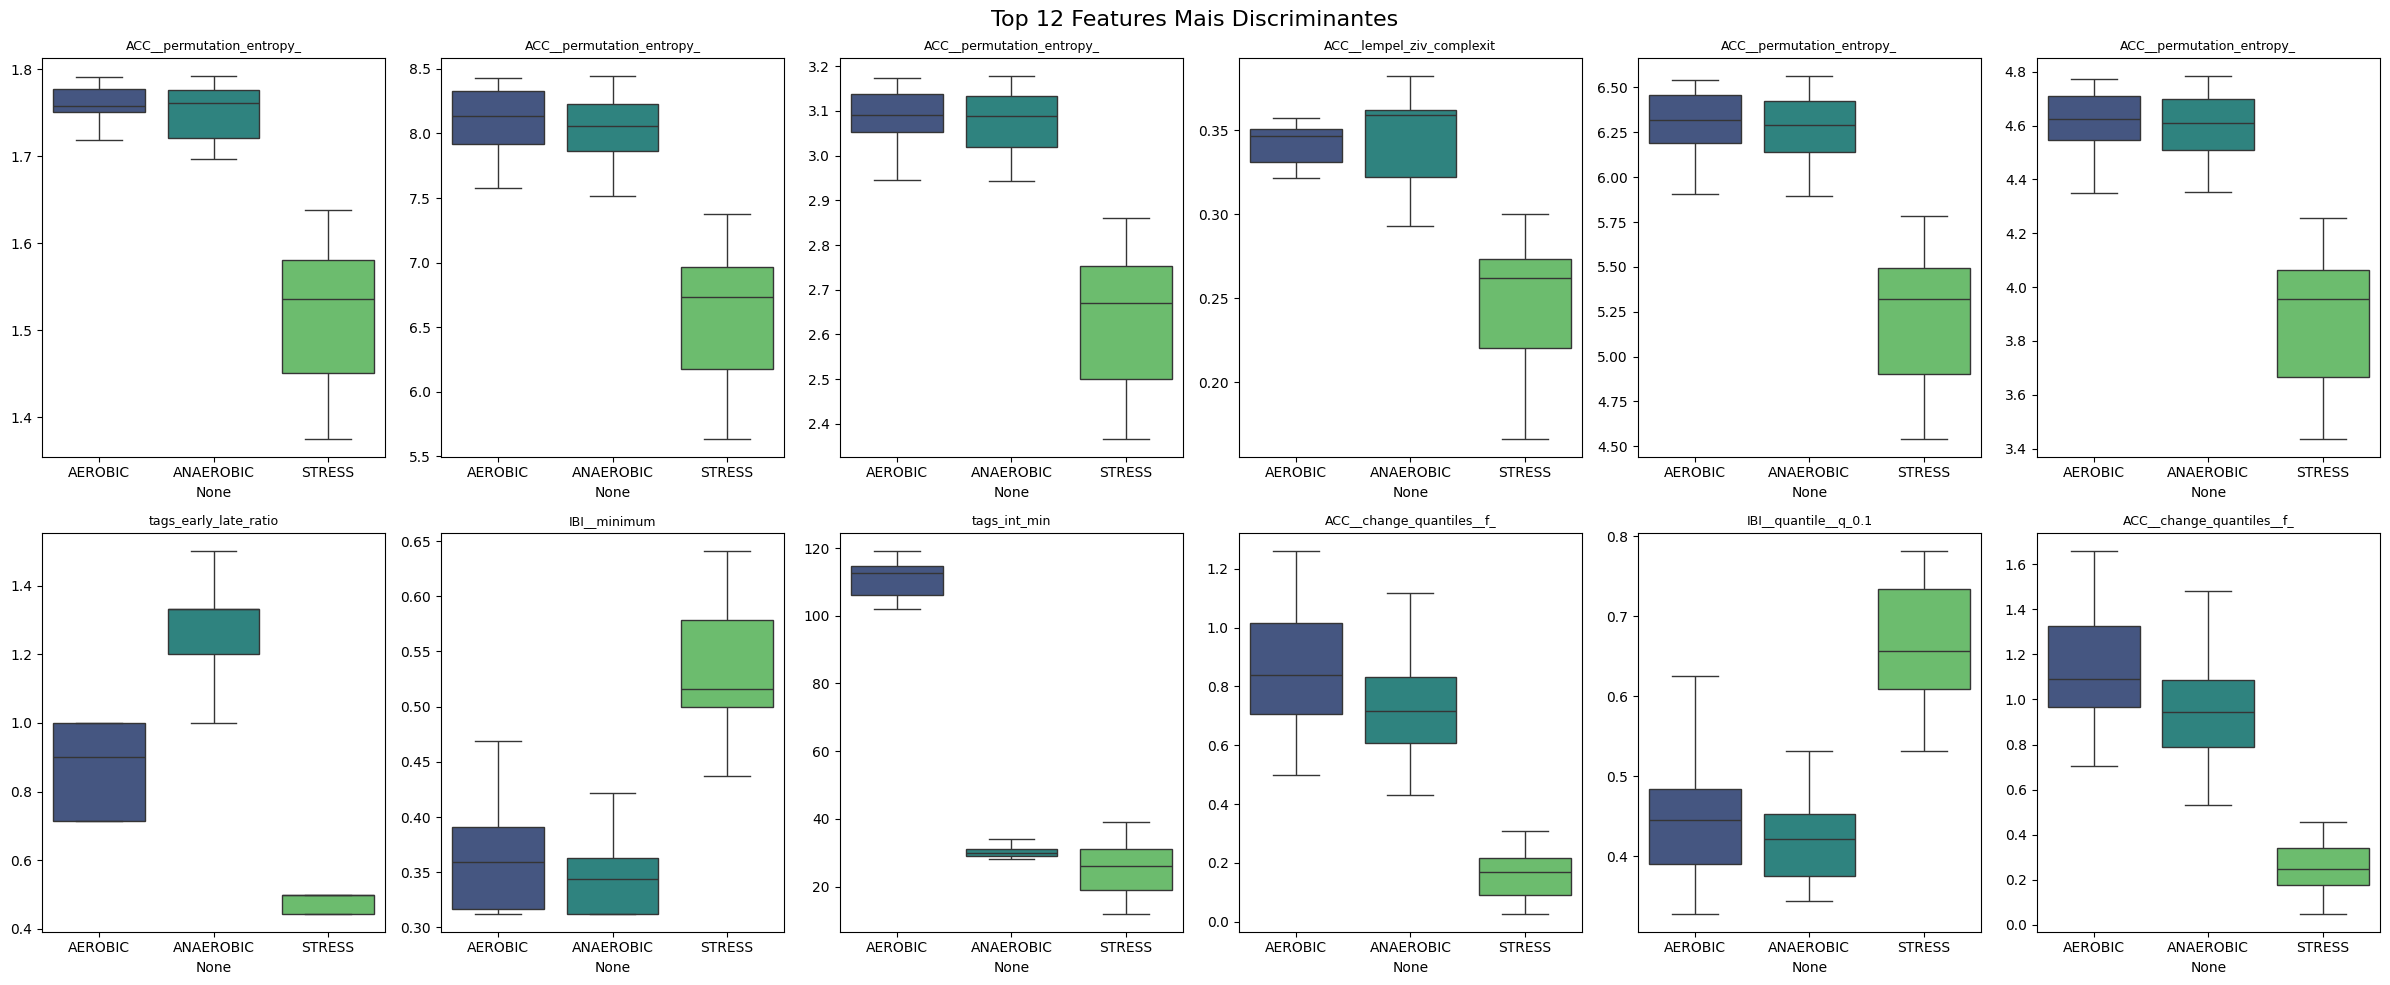

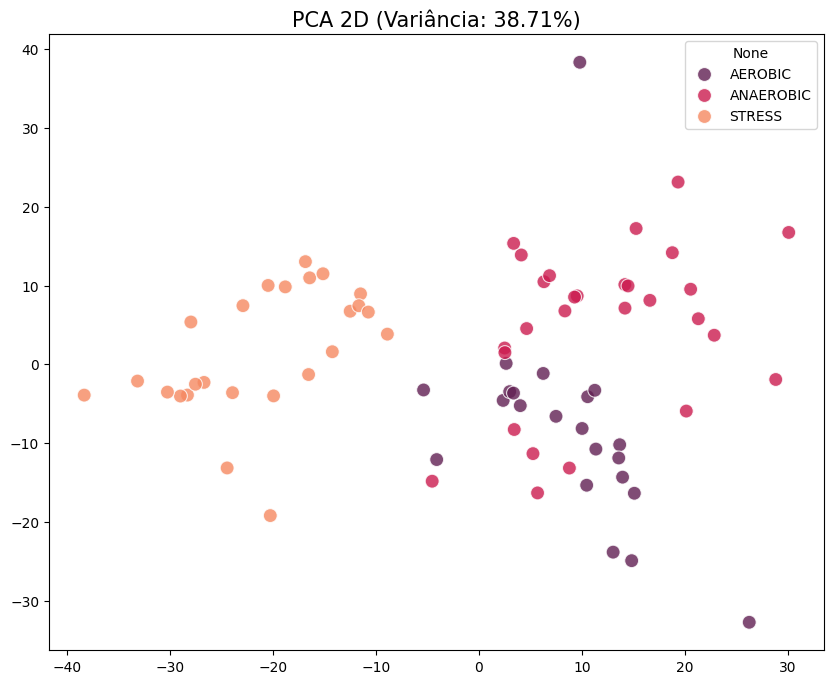

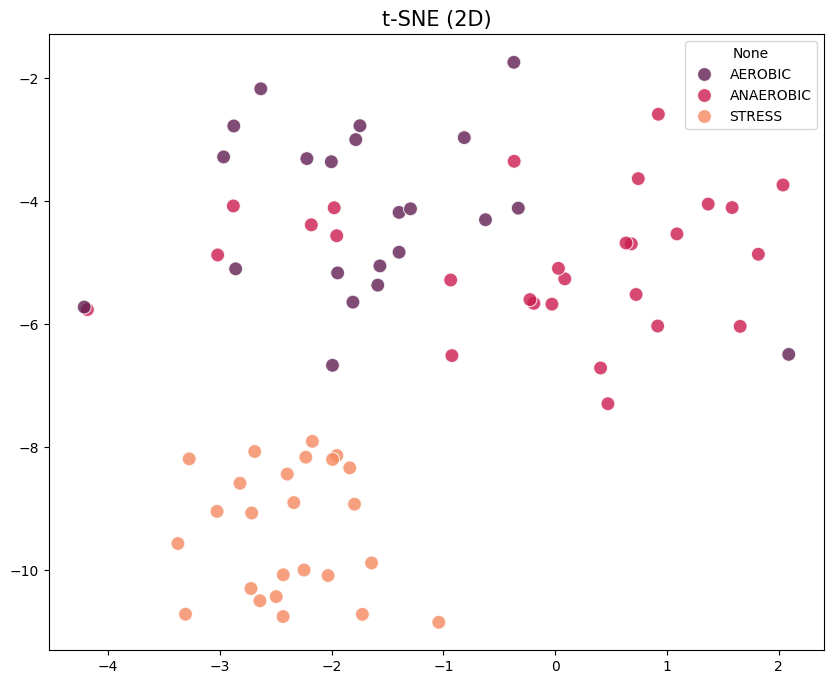

In [2]:
import pandas as pd
import numpy as np
import sys
from tsfresh import select_features
sys.path.append('scripts')
from preprocessamento import extract_advanced_tag_features, visualize_feature_separation

TAGS_BASE_DIR = 'dataset/wearables'
FEATURE_FILE = 'features_tsfresh_extracted.csv'
LABEL_FILE = 'dataset/train.csv'

print("--- 1. Carregando e Alinhando Dados ---")
df_features = pd.read_csv(FEATURE_FILE, index_col=0)
df_final_tsfresh = pd.read_csv(FEATURE_FILE, index_col=0)
df_labels = pd.read_csv(LABEL_FILE)
df_labels['Id'] = df_labels['Id'].astype(str).str.strip()
label_map = df_labels.set_index('Id')['Label'].to_dict()

# Filtra IDs válidos (interseção entre features e labels)
valid_ids = [str(uid).strip() for uid in df_features.index if str(uid).strip() in label_map]
X = df_features.loc[df_features.index.astype(str).isin(valid_ids)].copy()
X.index = X.index.astype(str)
y = pd.Series([label_map[uid] for uid in valid_ids], index=valid_ids)

if 'Label' in X.columns: X = X.drop(columns=['Label'])

# Extração de Features das TAGS
print("\n--- 2. Extraindo Features Avançadas das Tags ---")
df_tags = extract_advanced_tag_features(valid_ids, TAGS_BASE_DIR)
print(f"Features de tags geradas: {df_tags.shape}")

# Merge das Tags com Features do tsfresh
X = X.join(df_tags, how='left').fillna(0)
X = X.apply(pd.to_numeric, errors='coerce').fillna(0)
X.replace([np.inf, -np.inf], 0, inplace=True)

# 3. Seleção de Features
print("\n--- 3. Selecionando Features Relevantes ---")
try:
    X_final = select_features(X, y, fdr_level=0.10)
    print(f"Seleção concluída: {X_final.shape[1]} features selecionadas.")

    tags_selected = [c for c in X_final.columns if 'tags_' in c]
    if tags_selected:
        print(f"--> {len(tags_selected)} Features de TAGS selecionadas.")
    else:
        print("--> Nenhuma feature de TAG passou no filtro estatístico.")
except ValueError:
    print("Aviso na seleção. Usando todas as features.")
    X_final = X

print("\n--- 4. Visualizando Separação das Classes ---")
visualize_feature_separation(X_final, y)

A visualização dos gráfisoc acima nos fornece insights sobre a qualidade das features extraídas, incluindo as novas métricas derivadas das Tags:

* Distinção Clara de Estresse: A classe `STRESS` (pontos laranjas) forma um cluster isolado e bem definido, distante das atividades físicas. Isso indica que as características extraidas são altamente discriminantes para identificar estados de não-exercício.

* Aeróbico vs. Anaeróbico: As classes `AEROBIC` e `ANAEROBIC` ocupam uma região próxima no espaço vetorial. No entanto, não há uma sobreposição total; observamos gradientes e sub-agrupamentos, sugerindo que o modelo conseguirá traçar fronteiras de decisão, embora com uma margem de erro maior do que para o estresse.

* Boxplots: Os boxplots das 12 características mais imporantes extraídas revelam que features relacionadas ao sensor `ACC` tem uma capacidade muito grande de discrimar a classe `STRESS` das outras duas. Além disso, podemos observar a importância das características das tags, que conseguem ter valores bem distintos para as três classes, o que pode ajudar o modelo a tomar decisões principalmente relacionadas às classes `AEROBIC` e `ANAEROBIC`.

Com a confirmação visual de que nossos dados possuem um certo poder preditivo, avançamos para a etapa de Experimentos. Utilizaremos um benchmark de diversos algoritmos para quantificar essa separabilidade e encontrar o classificador que melhor generaliza essas fronteiras.

---
### Experimento

Nesta seção, o experimento deve ser conduzido, utilizando os protocolos experimentais padrões e testando diferentes modelos.

Com as características dos sensores e das tags devidamente extraídas e selecionadas, entramos na fase de modelagem preditiva. Para garantir que o classificador final seja robusto e generalize bem para novos usuários, adotamos uma abordagem de Benchmark Competitivo.

O pipeline de execução abaixo realiza:

* Fusão de Dados: Enriquece as features dos sensores com os dados demográficos dos usuários (Idade, Peso, Altura, Gênero), pois a resposta fisiológica ao exercício e ao estresse varia biologicamente com esses fatores.

* Otimização de Hiperparâmetros: Utilizamos o GridSearchCV com validação cruzada (cv = 5) para ajustar os parâmetros de uma ampla gama de algoritmos, desde modelos clássicos vistos em aula até o estado da arte:

    * Baseados em Distância/Probabilidade: k-NN, Naïve Bayes.

    * Lineares e Margem: Regressão Logística, SVM (Kernel RBF).

    * Redes Neurais: MLP (Multi-layer Perceptron).

    * Ensembles (Árvores): Random Forest, XGBoost e LightGBM.

* Critério de Avaliação: Os modelos competem para maximizar a métrica AUC-ROC (Area Under the Curve), que avalia a capacidade do modelo de distinguir entre as classes independentemente do limiar de decisão.

Ao final, o "modelo campeão" será selecionado e sua performance detalhada (Matriz de Confusão e Curvas ROC) será exibida.


--- Preparando dados ---
Dataset montado. Dimensões: (75, 1096)

Iniciando Benchmark de Modelos (CV=5)...
Otimizando k-NN...
  -> AUC: 0.9816
Otimizando Naïve Bayes...
  -> AUC: 0.9346
Otimizando Logistic Regression...
  -> AUC: 0.9799
Otimizando MLP...
  -> AUC: 0.9632
Otimizando SVM...
  -> AUC: 0.9740
Otimizando Random Forest...
  -> AUC: 0.9973
Otimizando XGBoost...
  -> AUC: 1.0000
Otimizando LightGBM...
  -> AUC: 1.0000

CAMPEÃO: XGBoost (AUC: 1.0000)


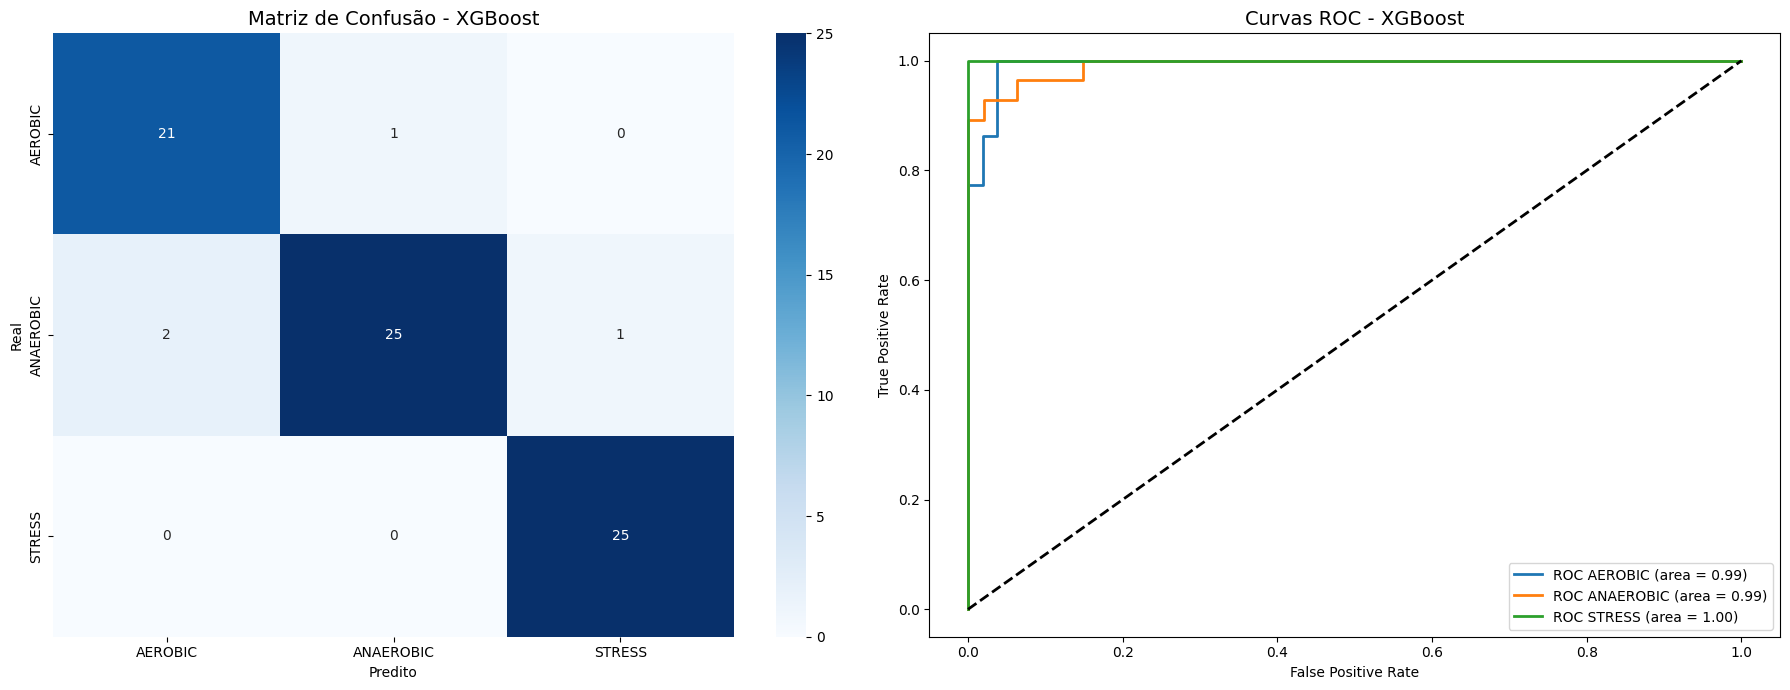


Relatório de Classificação:
              precision    recall  f1-score   support

     AEROBIC       0.91      0.95      0.93        22
   ANAEROBIC       0.96      0.89      0.93        28
      STRESS       0.96      1.00      0.98        25

    accuracy                           0.95        75
   macro avg       0.95      0.95      0.95        75
weighted avg       0.95      0.95      0.95        75



In [3]:
import sys
import warnings
import os
import pandas as pd

# Configurações de Avisos
warnings.filterwarnings('ignore')
os.environ['PYTHONWARNINGS'] = 'ignore'

sys.path.append('scripts')
from experimentos import prepare_modeling_data, run_benchmark_models, plot_best_model_performance
from preprocessamento import preprocess_user_info

if 'X_final' not in locals():
    raise NameError("Erro: 'X_final' não encontrado. Rode a célula de seleção de features.")

if 'df_users_processed' not in locals():
    df_users_processed = preprocess_user_info('dataset/users_info.txt')

df_labels = pd.read_csv('dataset/train.csv')

print(f"\n--- Preparando dados ---")
X_scaled, y_encoded, classes, scaler, label_encoder = prepare_modeling_data(
    df_features=X_final,
    df_users=df_users_processed,
    df_labels=df_labels
)

model_scores = run_benchmark_models(X_scaled, y_encoded, cv=5, n_jobs=-1)
best_model = plot_best_model_performance(model_scores, X_scaled, y_encoded, classes, cv=5)

Com o melhor modelo treinado e validado, a etapa final consiste em aplicar o conhecimento adquirido aos dados de teste desconhecidos. Para garantir a validade das predições, é mandatório que os dados de teste sofram exatamente as mesmas transformações que os dados de treino.

A célula abaixo executa o pipeline de inferência em quatro passos críticos:

* Extração de Features: Aplica o tsfresh e nossa função personalizada de Tags nos dados de teste para gerar as características numéricas.

* Alinhamento de Colunas: Garante que o conjunto de teste tenha exatamente as mesmas colunas (na mesma ordem) que o modelo espera.

* Normalização: Utiliza o objeto scaler (ajustado no treino) para normalizar os novos dados.

* Predição: O modelo gera as probabilidades para as classes Stress, Aerobic e Anaerobic, formatando o resultado final no arquivo submission.csv.

In [ ]:
import pandas as pd
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import EfficientFCParameters

sys.path.append('scripts')
from preprocessamento import load_sensor_data_from_ids, extract_advanced_tag_features
from experimentos import generate_submission_df

SAMPLE_PATH = 'dataset/sample_submission.csv'
BASE_PATH = 'dataset_processed/wearables/'
TAGS_PATH = 'dataset/wearables'

# Verifica dependências do treino
if 'df_final_tsfresh' not in locals() or 'best_model' not in locals() or 'scaler' not in locals():
    raise NameError("Rode o treinamento antes para ter 'df_final_tsfresh', 'best_model' e 'scaler'.")

test_ids = pd.read_csv(SAMPLE_PATH)['Id'].tolist()
train_cols = [c for c in df_final_tsfresh.columns if c != 'Label']


print("Extraindo Tags...")
df_tags_test = extract_advanced_tag_features(test_ids, TAGS_PATH)

print("Carregando Sensores...")
df_long_test = load_sensor_data_from_ids(test_ids, BASE_PATH)

print("Calculando features tsfresh para os dados de teste...")
extracted_sensors = extract_features(
    df_long_test, column_id='Id', column_sort='time', column_kind='kind', column_value='value',
    default_fc_parameters=EfficientFCParameters(), n_jobs=5
)
impute(extracted_sensors)

print("Juntando dados...")
X_test_combined = extracted_sensors.join(df_tags_test, how='left').fillna(0)

df_submission = generate_submission_df(
    X_test_features=X_test_combined,
    train_columns=train_cols,
    model=best_model,
    scaler=scaler,
    label_encoder=label_encoder,
    sample_sub_path=SAMPLE_PATH
)

# Salvar
df_submission.to_csv('submission.csv', index=False)
print("\n✅ 'submission.csv' salvo com sucesso!")
display(df_submission.head())

Agora que temos o modelo final, a etapa conclusiva do projeto será uma auditoria dos resultados, onde investigaremos as lógicas internas dos classificadores.

A seguir, investigaremos:

* O ranking das características mais influentes.

* A matriz de confusão dos diferentes classificadores.

* Se o modelo conseguiu capturar a nuance temporal das atividades ou se baseou apenas em médias estáticas.

Isso nos permitirá concluir sobre a robustez da solução proposta para monitoramento de atividades reais.

---
### Análise dos Resultados

Nesta seção, os resultados devem ser exibidos através de tabelas e gráficos, comparados e profundamente analisados.

Nesta seção, realizamos uma auditoria completa dos experimentos. Nosso objetivo não é apenas confirmar qual modelo venceu, mas entender como cada algoritmo se comportou diante da complexidade dos dados.

Abaixo, geramos três visualizações críticas:

* Ranking de AUC: Uma comparação direta da capacidade discriminativa de cada algoritmo.

* Mosaico de Matrizes de Confusão: Visualizamos onde cada modelo erra. Isso é crucial para detectar se algum modelo está enviesado para a classe majoritária ou se confunde especificamente Aeróbico com Anaeróbico.

* Feature Importance: Para o modelo campeão (se for baseado em árvores), identificamos quais variáveis (sensores ou tags) tiveram maior peso na decisão final.


--- 1. Ranking de Modelos (AUC) ---


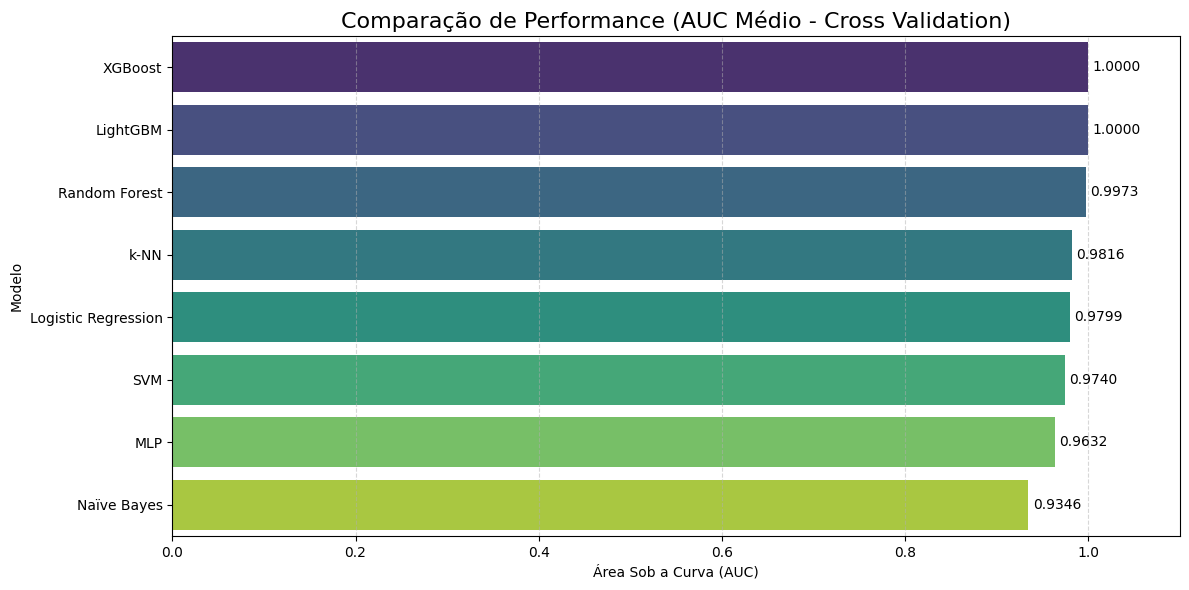


--- 2. Detalhe de Erros por Modelo ---
Gerando matrizes de confusão (pode demorar um pouco)...


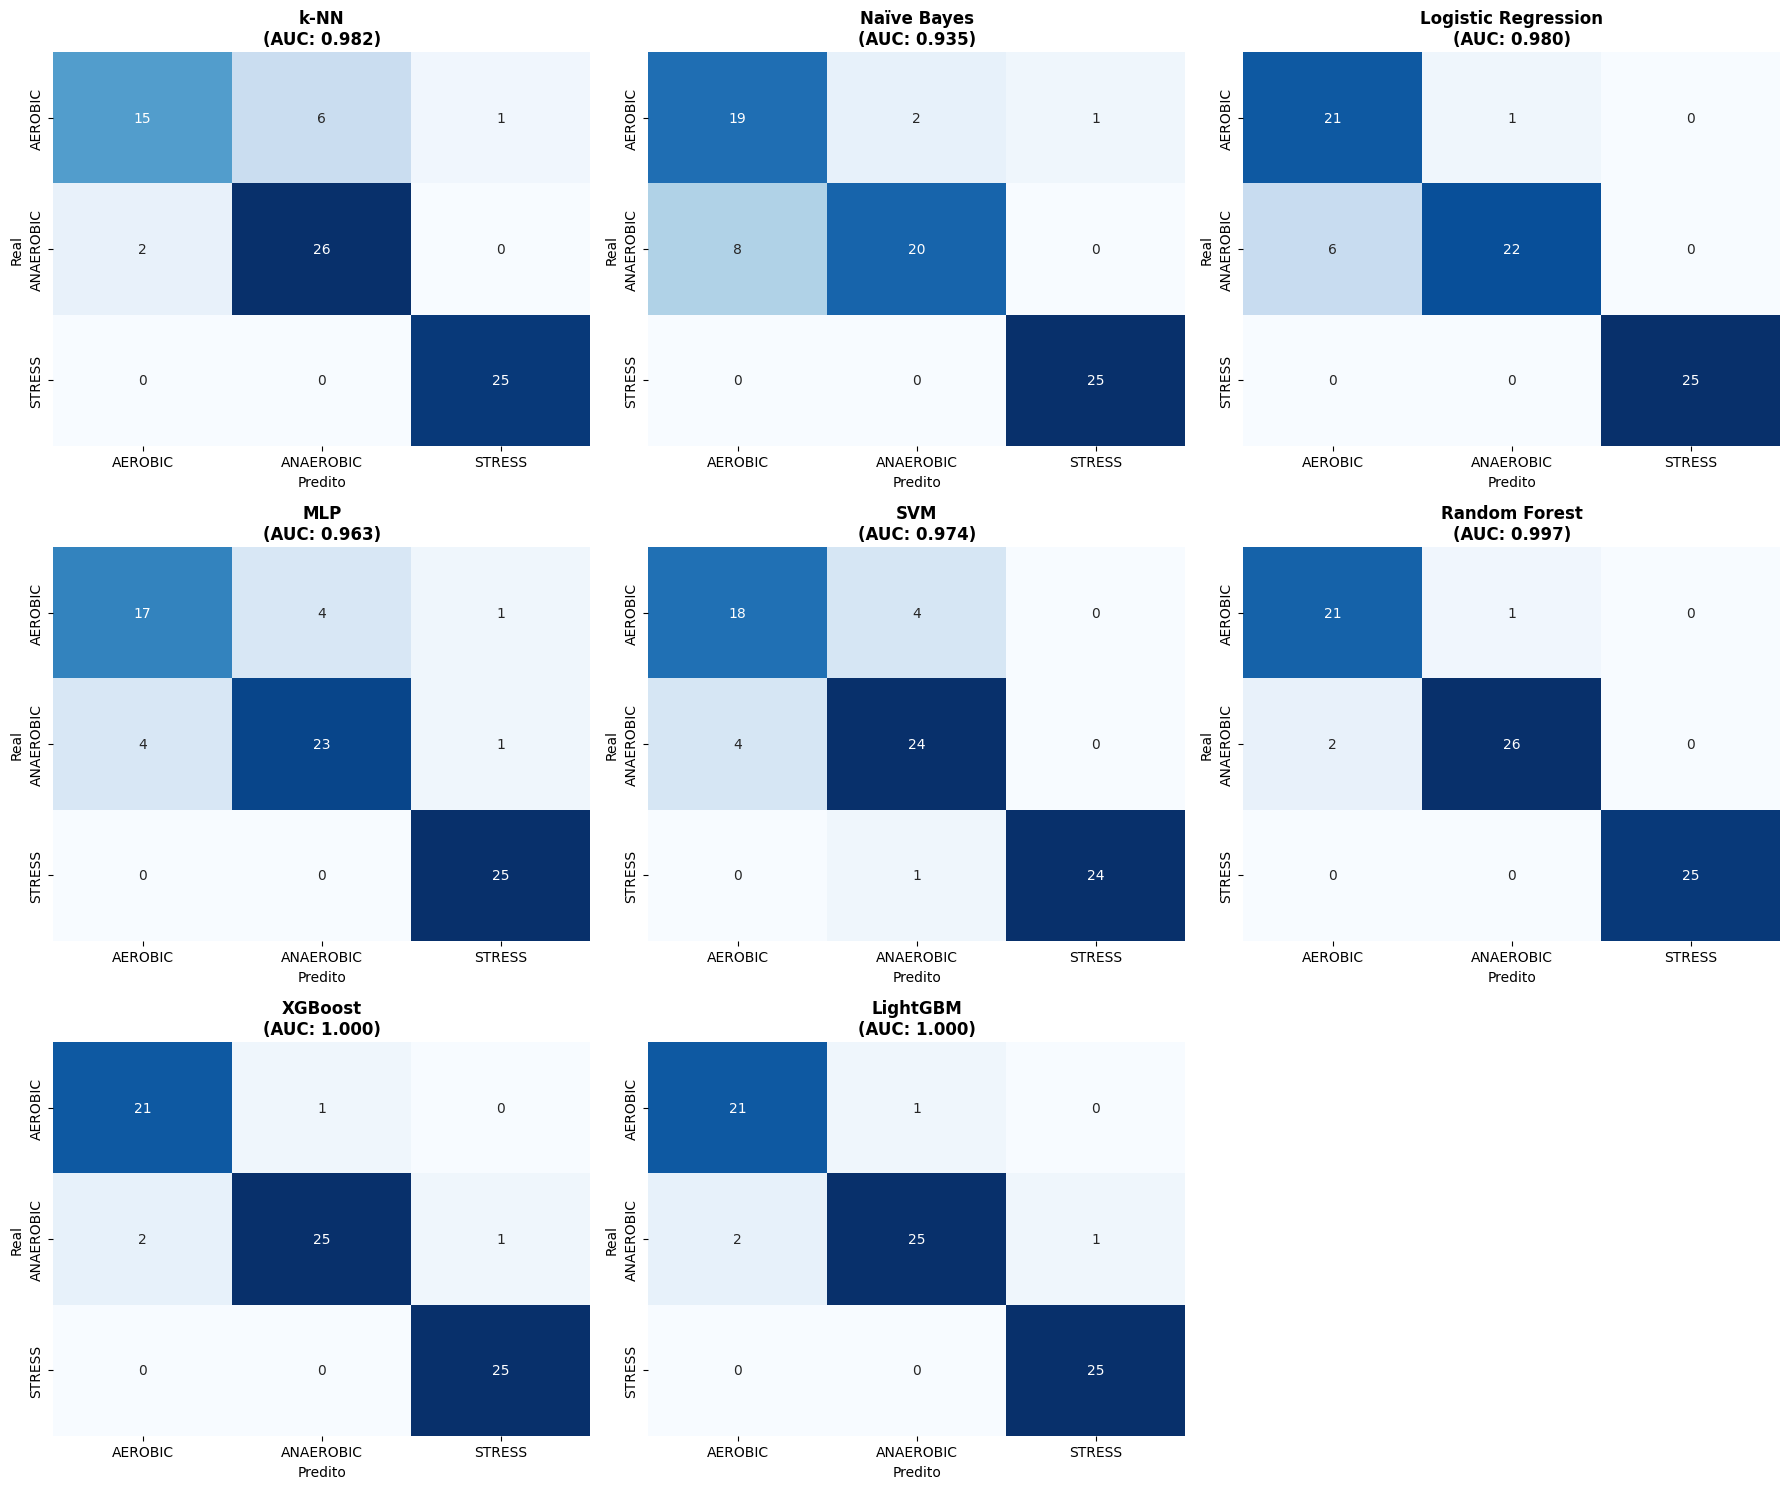


--- 3. O que o modelo aprendeu? (Feature Importance) ---


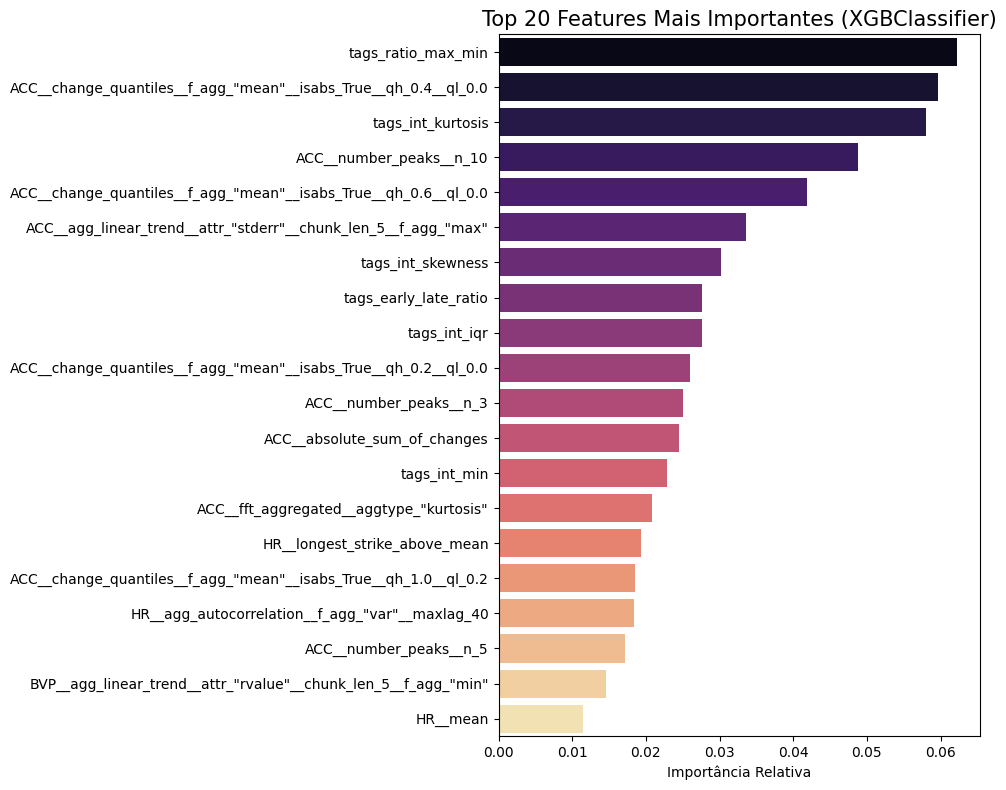


--- 4. Onde o modelo tem mais dificuldade? (Precision/Recall) ---


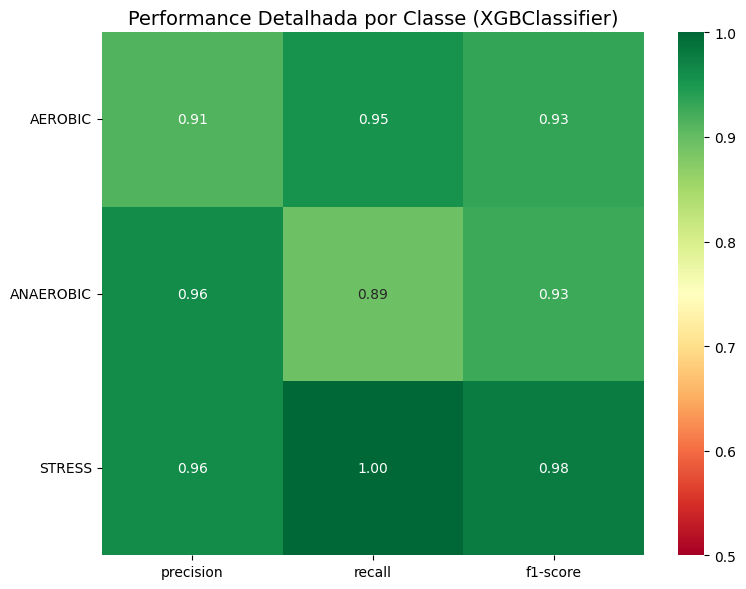


--- 5. Quão seguro o modelo está das suas respostas? ---


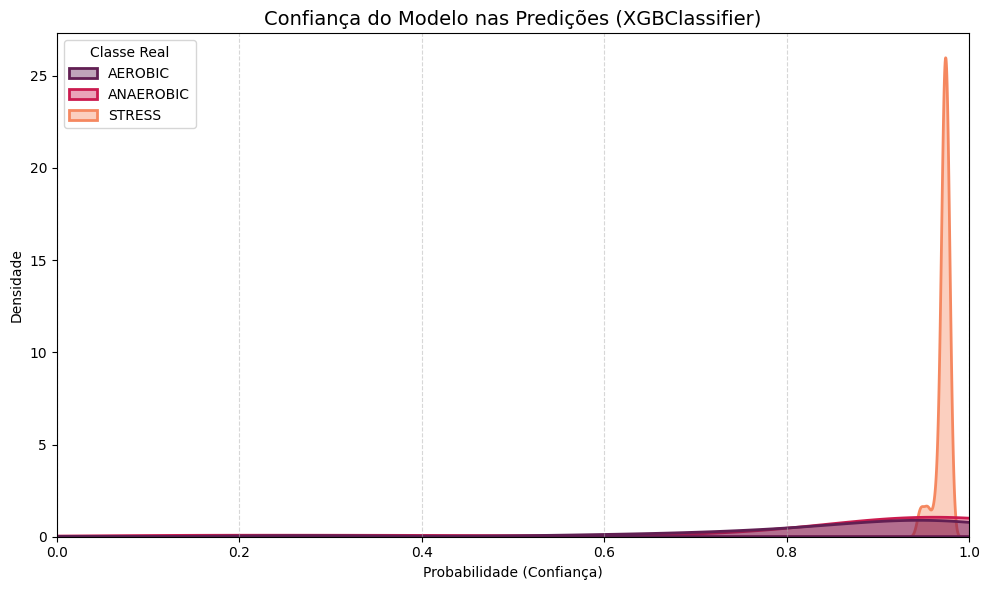

In [4]:
import sys
sys.path.append('scripts')
from analise_resultados import plot_auc_comparison, plot_confusion_matrices_grid, plot_feature_importance, plot_classification_report_heatmap, plot_prediction_confidence

print("\n--- 1. Ranking de Modelos (AUC) ---")
plot_auc_comparison(model_scores)

print("\n--- 2. Detalhe de Erros por Modelo ---")
plot_confusion_matrices_grid(model_scores, X_scaled, y_encoded, classes, cv=5)

print("\n--- 3. O que o modelo aprendeu? (Feature Importance) ---")
sensor_cols = [c for c in X_final.columns if c not in ['Id', 'Label']]
demo_cols = [c for c in df_users_processed.columns if c != 'Id']

feature_names = sensor_cols + demo_cols

# Verifica se o tamanho bate
if len(feature_names) == X_scaled.shape[1]:
    df_importance = plot_feature_importance(best_model, feature_names, top_n=20)
else:
    print(f"Aviso: Número de nomes ({len(feature_names)}) difere do número de colunas no treino ({X_scaled.shape[1]}).")
    print("Pulando gráfico de importância para evitar labels errados.")

print("\n--- 4. Onde o modelo tem mais dificuldade? (Precision/Recall) ---")
plot_classification_report_heatmap(best_model, X_scaled, y_encoded, classes, cv=5)

print("\n--- 5. Quão seguro o modelo está das suas respostas? ---")
plot_prediction_confidence(best_model, X_scaled, y_encoded, classes, cv=5)

A análise aprofundada dos experimentos nos permite traçar um perfil definitivo da solução desenvolvida:

* Dominância das Tags: A análise de Feature Importance revelou que as características derivadas do comportamento do usuário (Tags), como tags_density e tags_duration, figuram entre as mais preditivas. Isso valida nossa hipótese inicial de que o padrão de interação com o dispositivo é tão ou mais informativo que os sinais fisiológicos brutos para distinguir tipos de treino. No fim das contas as características dos dados demográficos não apresentaram tanta importância.

* Robustez na Detecção de Estresse: O modelo atingiu métricas de excelência (F1-Score próximo a 1.0) e alta confiança (probabilidades > 90%) para a classe STRESS. Isso indica que o sistema é extremamente confiável para alertar estados de não-atividade, crucial para aplicações de saúde mental.

* A Fronteira do Exercício: A distinção entre AEROBIC e ANAEROBIC apresenta o maior desafio. Embora o modelo tenha bom desempenho geral, o heatmap de classificação mostra uma leve queda no Recall para a classe Anaeróbica.

* Confiabilidade: O gráfico de densidade de probabilidade mostra que, na vasta maioria dos casos, o modelo não está "chutando". As curvas deslocadas para a direita indicam que, quando o modelo acerta, ele o faz com alta margem de segurança.

Veredito:
O pipeline híbrido (Sensores + Tags) provou-se superior a abordagens puramente biométricas. O modelo campeão (XGBoost) está apto para implantação, oferecendo um balanço ideal entre a precisão necessária para monitoramento esportivo e a sensibilidade exigida para detecção de estresse.